# Load raw dataset

In [2]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile, expandvars

# data
zenith = 'random' # 'z20' # 
table = 'regressor_5sgm_xy_flip.pickle'
path = f'{expandvars("$HOME")}/E4/irf_{zenith}/crab/'
dataset = join(path, table)

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
    gammatable = join(path, table.replace('.pickle', '_gammapy.txt'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))
    gammatable = join(path, table.replace('.npy', '_gammapy.txt'))
    
ds = np.array(ds['DS'])
ds = ds.reshape(ds.shape[0], ds.shape[1], ds.shape[2], 1)
ds.shape

(20000, 200, 200, 1)

# Infotable

In [3]:
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
infodata.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
15000,crab_00001,1,0,100,100,57.265654,30.447065,57.253328,30.454269,0.012838,North_z40_S_0.5h_LST,2.5,7.322825
15001,crab_00002,2,0,100,100,98.177801,40.950640,98.016897,41.081760,0.178695,North_z60_N_50h_LST,2.5,6.762409
15002,crab_00003,3,0,100,100,76.984211,-66.348920,78.358890,-67.138246,0.957894,North_z40_N_5h_LST,2.5,7.029939
15003,crab_00004,4,0,100,100,125.495725,-44.424075,126.479118,-43.608941,1.079135,North_z40_5h_LST,2.5,7.074566
15004,crab_00005,5,0,100,100,214.162576,42.736282,215.790559,43.357500,1.342109,North_z20_5h_LST,2.5,7.087336


# Gammatable

In [4]:
gammadata = pd.read_csv(gammatable, sep=' ', header=0).sort_values(by=['seed'])
gammadata.head()

,seed,loc_ra,loc_dec,counts_on,counts_off,excess,excess_err,sigma,snr
0,1,57.267818,30.441771,NaN,NaN,NaN,NaN,NaN,NaN
1,2,98.165826,40.944170,NaN,NaN,NaN,NaN,NaN,NaN
2,3,76.894712,-66.343824,145.0,617.0,93.583333,27.604347,10.048215,3.510678
3,4,125.480814,-44.467154,189.0,708.0,138.428571,29.949958,14.058160,4.758067
4,5,214.105104,42.757503,161.0,771.0,118.166667,30.528675,13.177265,3.962811


# Pick seed

In [20]:
idx = np.random.choice(range(len(ds)))
#idx = 19714 # 4205
# find seed to get the original heatmap
seed = idx + 1
print(seed)

1490


In [21]:
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
16489,crab_01490,1490,0,100,100,330.377884,36.431666,330.064544,35.687457,0.786135,North_z40_S_5h_LST,2.5,7.021031


In [22]:
grow = gammadata[gammadata['seed']==seed]
grow

,seed,loc_ra,loc_dec,counts_on,counts_off,excess,excess_err,sigma,snr
1489,1490,330.390742,36.424516,283.0,488.0,228.777778,27.766887,19.809854,8.545187


# Set WCS

In [23]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

# Models

In [24]:
# models
cnnname = 'cleaner_zALL'
savename = 'regressor_zALL' 

# Denoise dataset

In [25]:
import tensorflow as tf

root = f'{expandvars("$HOME")}/astroAI/astroai/'
model = tf.keras.models.load_model(join(root, 'models/crta_models', f'{cnnname}.keras'))
predictions = model.predict(ds)

2024-12-17 15:38:03.664113: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3200000000 exceeds 10% of free system memory.


625/625 [==============================] - 30s 48ms/step


2024-12-17 15:38:38.016340: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3200000000 exceeds 10% of free system memory.


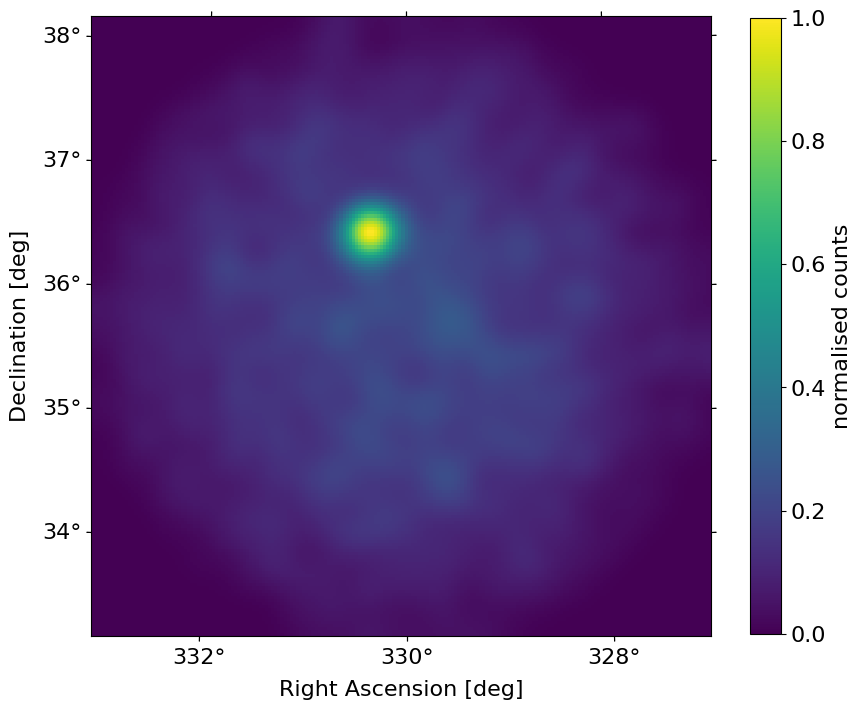

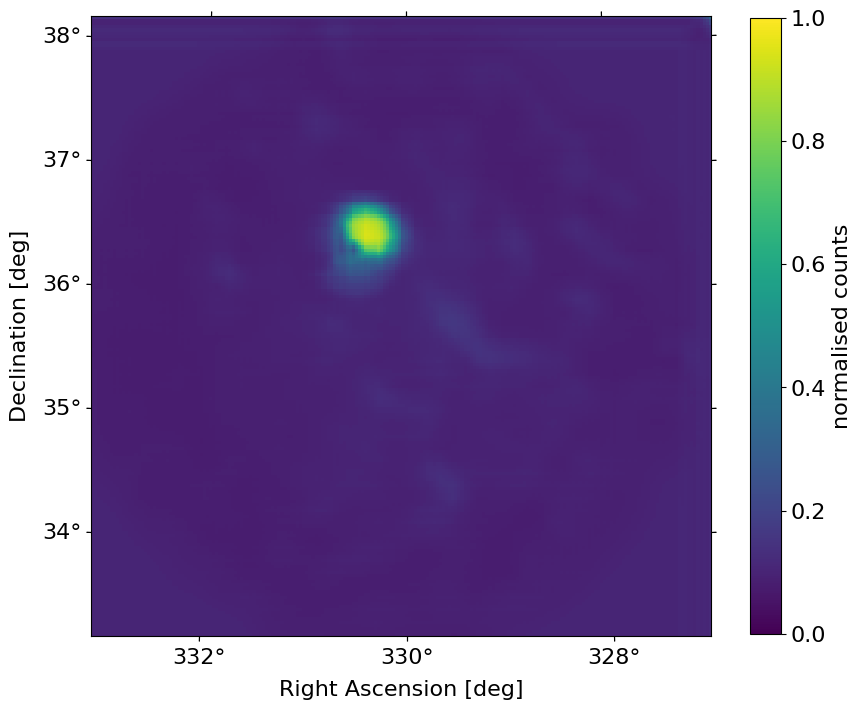

In [26]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
figsize = (10, 10)
fs = 16
lw = 2

# NOISY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
    
img = ax.imshow(ds[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'simulated map {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_noisy_no_loc.png')
plt.show()

# CLEAN
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)

img = ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'predicted map {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_clean_no_loc.png')
plt.show()

# Localise candidates

In [27]:
import tensorflow as tf

model = tf.keras.models.load_model(f'../models/crta_models/{savename}.keras')
candidates = model.predict(predictions) * binning

625/625 [==============================] - 34s 52ms/step


In [28]:
row['source_ra'].values[0]

330.3778842299314

In [29]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

# TRUE
true_sky = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')
x, y = w.world_to_pixel(true_sky) 
true_sky = true_sky.ra.deg, true_sky.dec.deg
true_pix = x, y

# PREDICTION
pred_pix = candidates[idx]
sky = w.pixel_to_world(pred_pix[0], pred_pix[1])
pred_sky = sky.ra.deg, sky.dec.deg

# GAMMAPY
gamma_sky = SkyCoord(ra=grow['loc_ra'].values[0], dec=grow['loc_dec'].values[0], unit='deg', frame='icrs')
x, y = w.world_to_pixel(gamma_sky) 
gamma_sky = gamma_sky.ra.deg, gamma_sky.dec.deg
gamma_pix = x, y

print(f'SEED: {seed}')
print('---- PIX')
print(f"true: {true_pix}")
print(f"prediction: {pred_pix}")
print(f"gammapy: {gamma_pix}")
print('---- SKY')
print(f"true: {true_sky} ")
print(f"prediction: {pred_sky}")
print(f"gammapy: {gamma_sky}")

SEED: 1490
---- PIX
true: (array(88.94005549), array(128.80945934))
prediction: [ 87.48842  126.363495]
gammapy: (array(88.52528858), array(128.52480189))
---- SKY
true: (330.3778842299314, 36.43166645998416) 
prediction: (330.42270917186795, 36.370393644106116)
gammapy: (330.39074160469494, 36.42451630191833)


/tmp/ipykernel_3843862/4241721252.py:25: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 1000x1000 with 2 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(img, ax=ax, shrink=0.7)


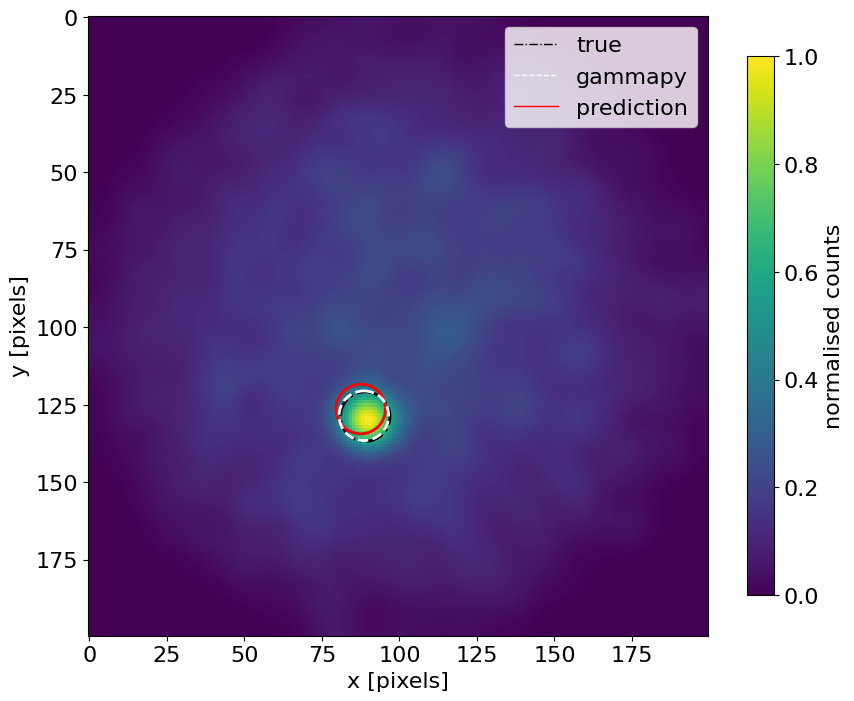

/tmp/ipykernel_3843862/4241721252.py:50: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 1000x1000 with 2 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(img, ax=ax, shrink=0.8)


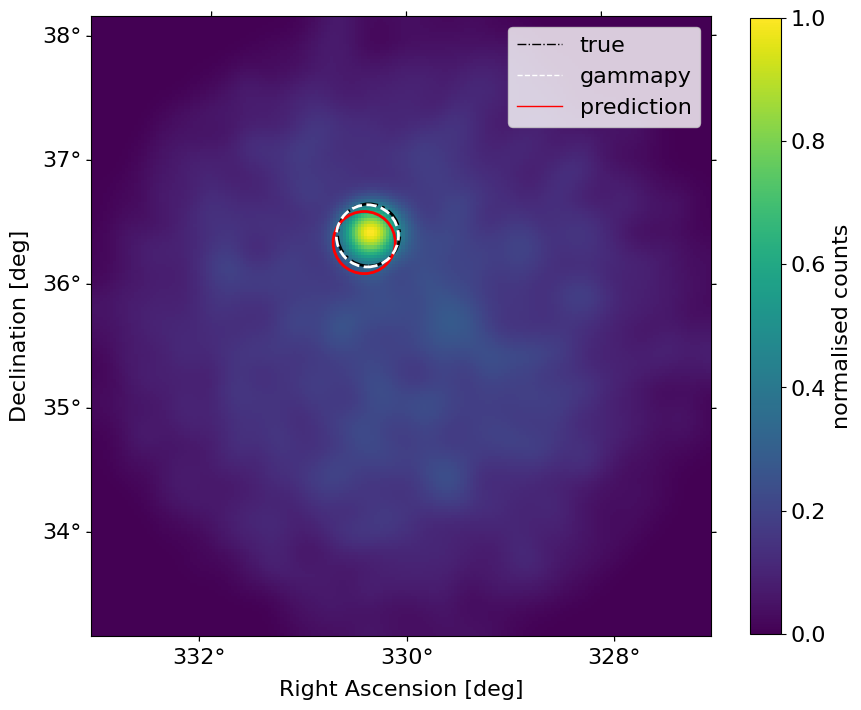

In [30]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
sz = 2e3

# LEGENDS
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='w', lw=1, ls='--'),
                Line2D([0], [0], color='r', lw=1, ls='-')]

# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.imshow(ds[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.', lw=lw))
ax.add_patch(plt.Circle((pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-', lw=lw))
ax.add_patch(plt.Circle((gamma_pix), radius=radius_pix, edgecolor='w', facecolor='none', ls='--', lw=lw))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
#ax.set_title(f'simulated map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, ['true', 'gammapy', 'prediction'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.7)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_noisy_pix_loc_3.png')
plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
ax.imshow(ds[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='k', facecolor='none', ls='-.', lw=lw)
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='r', facecolor='none', ls='-', lw=lw)
ax.scatter(gamma_sky[0], gamma_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='w', facecolor='none', ls='--', lw=lw)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'predicted map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, ['true', 'gammapy', 'prediction'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_noisy_sky_loc_3.png')
plt.show()


/tmp/ipykernel_3843862/1272735550.py:25: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 1000x1000 with 2 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(img, ax=ax, shrink=0.7)


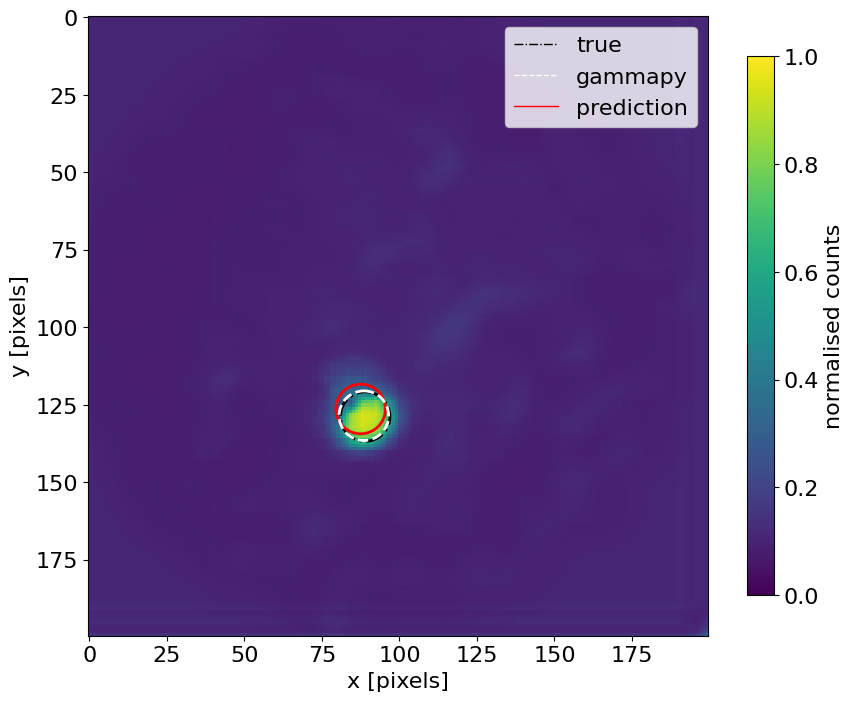

/tmp/ipykernel_3843862/1272735550.py:50: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 1000x1000 with 2 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(img, ax=ax, shrink=0.8)


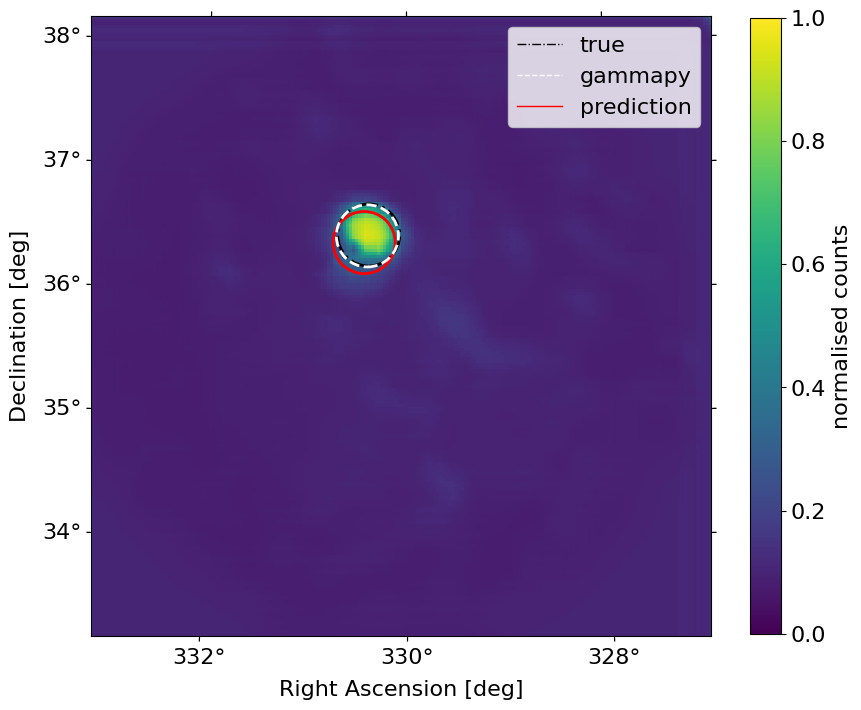

In [31]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
sz = 2e3

# LEGENDS
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='w', lw=1, ls='--'),
                Line2D([0], [0], color='r', lw=1, ls='-')]

# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.', lw=lw))
ax.add_patch(plt.Circle((pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-', lw=lw))
ax.add_patch(plt.Circle((gamma_pix), radius=radius_pix, edgecolor='w', facecolor='none', ls='--', lw=lw))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
#ax.set_title(f'simulated map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, ['true', 'gammapy', 'prediction'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.7)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_clean_pix_loc_3.png')
plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='k', facecolor='none', ls='-.', lw=lw)
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='r', facecolor='none', ls='-', lw=lw)
ax.scatter(gamma_sky[0], gamma_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='w', facecolor='none', ls='--', lw=lw)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'predicted map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, ['true', 'gammapy', 'prediction'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_clean_sky_loc_3.png')
plt.show()


/tmp/ipykernel_3843862/3003574292.py:23: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 1000x1000 with 2 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(img, ax=ax, shrink=0.7)


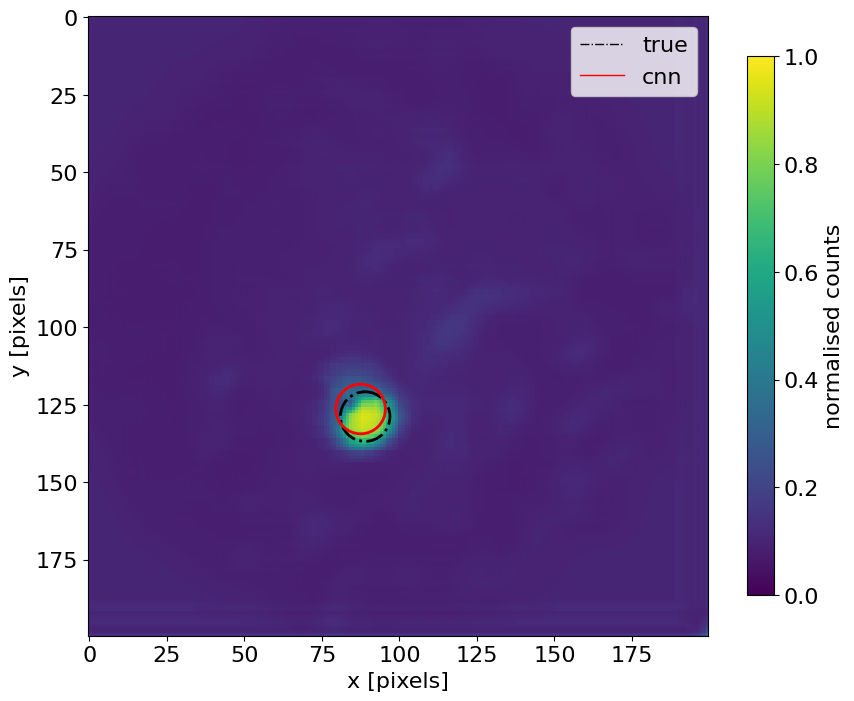

/tmp/ipykernel_3843862/3003574292.py:46: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 1000x1000 with 2 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(img, ax=ax, shrink=0.8)


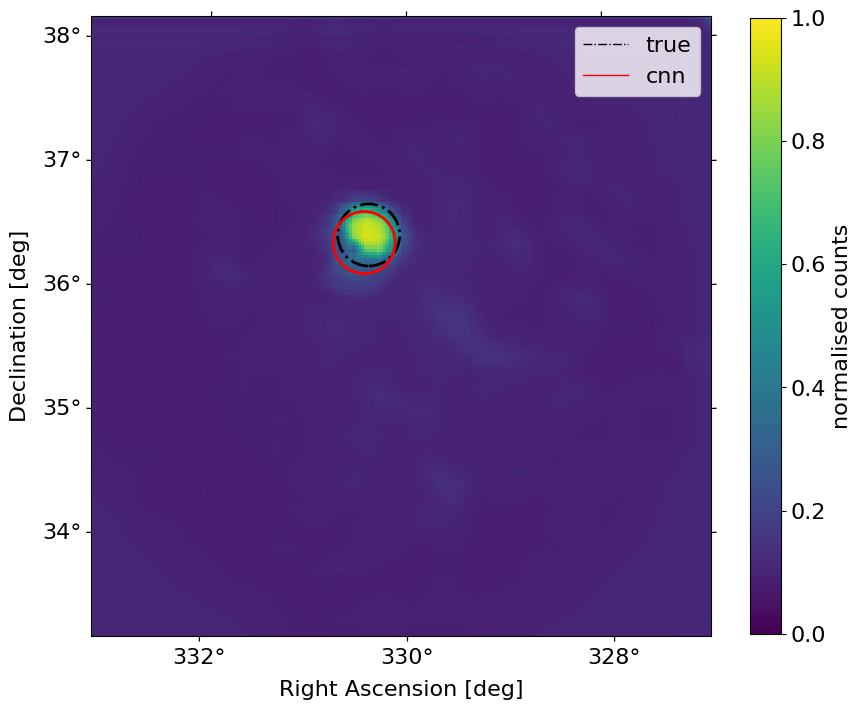

In [32]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
sz = 2e3

# LEGENDS
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='r', lw=1, ls='-')]

# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.', lw=lw))
ax.add_patch(plt.Circle((pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-', lw=lw))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
#ax.set_title(f'clean map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, ['true', 'cnn'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.7)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_clean_pix_loc_2.png')
plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='k', facecolor='none', ls='-.', lw=lw)
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='r', facecolor='none', ls='-', lw=lw)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'clean map {seed}', fontsize=fs*1.5)
ax.legend(custom_lines, ['true', 'cnn'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_clean_sky_loc_2.png')
plt.show()


/tmp/ipykernel_3843862/2333046674.py:22: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 1000x1000 with 2 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(img, ax=ax, shrink=0.7)


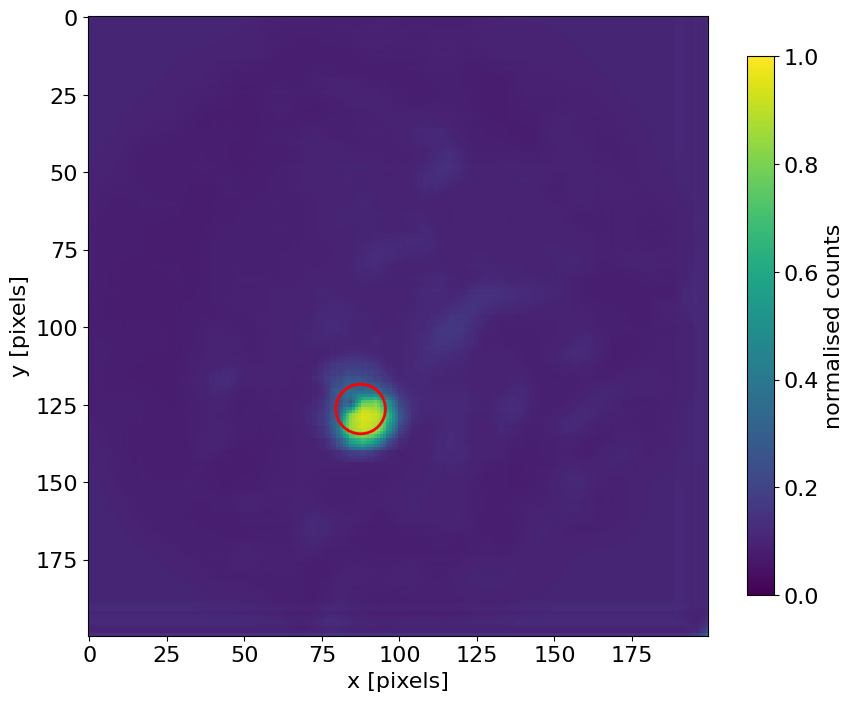

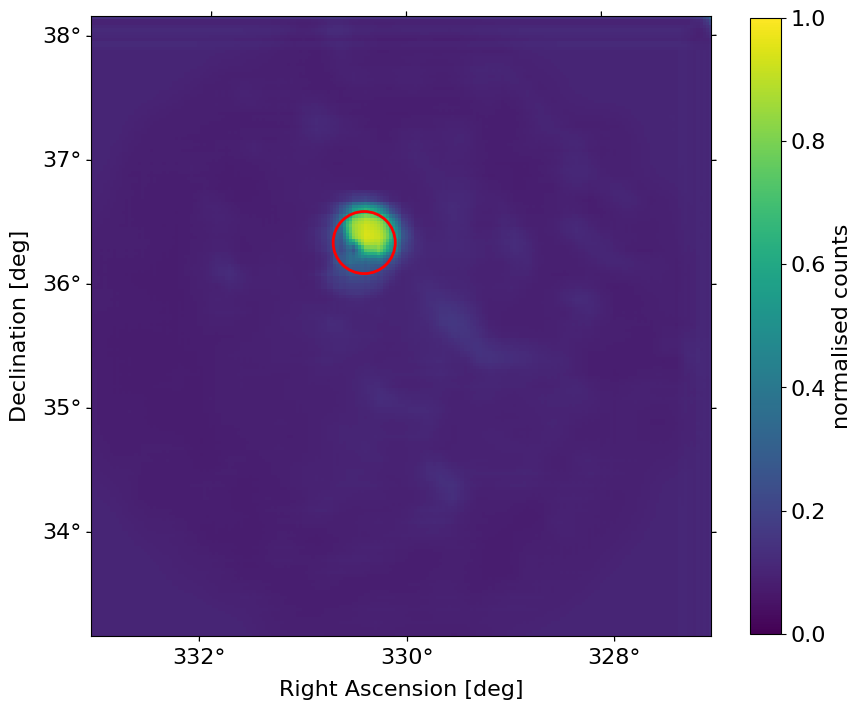

In [33]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
sz = 2e3

# LEGENDS
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='r', lw=1, ls='-')]

# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-', lw=lw))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
#ax.set_title(f'clean map {seed}', fontsize=fs*1.5)
#ax.legend(custom_lines, ['true', 'cnn'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.7)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_clean_pix_loc_1.png')
plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)

img = ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=sz,
              edgecolor='r', facecolor='none', ls='-', lw=lw)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
#ax.set_title(f'clean map {seed}', fontsize=fs*1.5)
#ax.legend(custom_lines, ['true', 'cnn'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/heatmap_{seed}_clean_sky_loc_1.png')
plt.show()
